# Modelo Final

## Previos

Se cargan las bases y las librerías a utilizar.

In [1]:
# Librerías

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests
import pydotplus

import lightgbm as lgb

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch

from joblib import dump, load
from scipy.stats import chi2_contingency, norm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.model_selection import GridSearchCV

from sympy import var, plot_implicit, Eq


#import generic_funcions as gf
#import adherence_functions as af
import warnings
warnings.filterwarnings('ignore')

ruta_archivos = 'C:/Users/monic/documentos/ds4a/ds4a_team80/1_data_transformation/'

C:\Users\monic\Anaconda3\envs\case_1.2_var2\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## 1. Variables Dataframe

In [2]:
base = pd.read_csv( ruta_archivos + 'base_adeherencia_features_3.csv', sep='|' )

In [3]:
print(base.shape)

base['adeherencia_12'] = (base['adeherencia_12']/base['cantidad']).apply(lambda x: 1 if x>=0.5 else 0)
#base['adeherencia_12'] = base['adeherencia_12'].apply(lambda x: 1 if x>=1 else x)

ids = ['id','year','month','adeherencia_12']
base.head()

(3717, 142)


,id,year,month,adeherencia_12,cantidad,key,far_rea_asma_sum_6,far_rea_total_sum_6,far_evo_aun_sum_6,far_cau_def_sum_6,...,hab_ejercicio_avg_12,inc_con_sum_6,inc_inc_sum_6,inc_con_sum_12,inc_inc_sum_12,imc_avg_6,imc_avg_12,imc_foto,adh_sum_6,adh_sum_12
0,500547,2016,7,0,1.0,1,NaN,NaN,NaN,NaN,...,NaN,0.0,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
1,500547,2019,3,0,4.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500547,2019,10,0,5.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,NaN,0.0
3,500547,2019,12,0,4.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,0.0,0.0
4,500547,2020,1,0,3.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,0.0,0.0


In [4]:
# Using variables vector of 'Mostrar' analysis.
vec2 = ['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12', 'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6', 'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12', 'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12', 'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6']
print(len(vec2))

15


In [5]:
def preprocesar( base, ids, ruta_archivos ):
    
    # Variables 
    vec2 = ['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12', 'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6', 'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12', 'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12', 'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6']
    base_nueva = base[ids + vec2]
    
    # Imputación
    base_nueva.fillna(-1,inplace = True)
    
    # Carga Datos Básicos
    datosbasicos = pd.read_csv( ruta_archivos + 'DatosBasicos.csv', sep='|' )
    datosbasicos.drop_duplicates( inplace = True )
    datosbasicos.dropna( inplace = True )
    
    # Se dejan sólo ids únicos
    ids_count = datosbasicos.groupby('id').count()['year_n'].reset_index(name='cuenta')
    ids_unicos = ids_count[ids_count['cuenta']==1]
    datosbasicos = datosbasicos.merge(ids_unicos, how = 'inner')
    
    # Cruce datos básicos
    Agregada = base_nueva.merge(datosbasicos, on="id", how ='inner')
    
    
    # Procesamiento variables
    Agregada['edad'] = round((Agregada['year'] - Agregada['year_n']) + (Agregada['month'] - Agregada['month_n'])/12,0)
    Agregada.drop(columns=['Unnamed: 0', 'cuenta', 'fecha_n', 'year_n', 'month_n'], inplace= True)
    
    ### Variables categoricas
    categorias = ['genero', 'zona', 'ciudad']
    
    for var in categorias:
        Agregada[var] = Agregada[var].astype('category')
        Agregada[var]=Agregada[var].cat.codes
    
    # Escolaridad
    letras = ['ANALFABETA', 'EDAD PREESCOLAR', 'PRIMARIA', 'SECUNDARIA', 'TECNICO', 'TECNOLOGO', 'UNIVERSITARIO', 'POSGRADO']
    valor = [0,1,2,3,4,5,6,7]
    Agregada.replace(letras, valor,inplace = True)
    
    # Estado civil
    letras = ['SOLTERO (A)', 'UNIÓN LIBRE', 'CASADO (A)', 'SEPARADO (A)', 'VIUDO (A)']
    valor = [0,1,2,3,4]
    Agregada.replace(letras, valor,inplace = True)
    
    # Nivel socioeconomico
    letras = ['NIVEL 0 DEL SISBEN', 'NIVEL 1 DEL SISBEN', 'NIVEL 2 DEL SISBEN', 'A', 'B', 'C']
    valor = [0,1,2,3,4,5]
    Agregada.replace(letras, valor,inplace = True)
    
    # Ocupacion
    letras = ['SIN DEFINIR', 'ESTUDIANTE', 'DESEMPLEADO', 'AMA DE CASA', 'INDEPENDIENTE', 'EMPLEADO', 'JUBILADO', 'PENSIONADO']
    valor = [0,1,2,3,4,5,6,7]
    Agregada.replace(letras, valor,inplace = True)
    
    Agregada = Agregada.drop('departamento', axis=1 )
        
    return Agregada

In [6]:
def matrix_c( y_real, y_pred ):

    cnf_matrix = confusion_matrix(y_real, y_pred)
    
    total1=sum(sum(cnf_matrix))
    
    # Metrics
    accuracy1= round((cnf_matrix[0,0]+cnf_matrix[1,1])/total1, 2)
    print ('Accuracy : ', accuracy1)

    sensitivity1 = round(cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1]), 2)
    print('Sensitivity : ', sensitivity1 )

    specificity1 = round(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), 2)
    print('Specificity : ', specificity1)
    
    return cnf_matrix

In [7]:
df_t = preprocesar( base, ['id', 'year', 'month', 'adeherencia_12'], ruta_archivos )
df_t.shape #(3671, 28)

(3671, 28)

In [8]:
df_t.head()

,id,year,month,adeherencia_12,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,...,adh_sum_6,genero,escolaridad,estadocivil,ciudad,estrato,zona,nivelsocioeconomico,ocupacion,edad
0,500547,2016,7,0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.0,1,3,2,26,3.0,1,3,5,54.0
1,500547,2019,3,0,-1.0,1021.800000,-1.0,-1.0,-1.0,-1.0,...,-1.0,1,3,2,26,3.0,1,3,5,57.0
2,500547,2019,10,0,-1.0,259.200000,-1.0,-1.0,-1.0,3.0,...,-1.0,1,3,2,26,3.0,1,3,5,57.0
3,500547,2019,12,0,-1.0,596.833333,-1.0,-1.0,-1.0,3.0,...,0.0,1,3,2,26,3.0,1,3,5,58.0
4,500547,2020,1,0,-1.0,732.000000,-1.0,-1.0,-1.0,3.0,...,0.0,1,3,2,26,3.0,1,3,5,58.0


## 2. Covariables

In [9]:
covariates=df_t.columns[4:]

## 3. Modelos

In [9]:
X = df_t[covariates]
y = df_t['adeherencia_12']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Logistic Regression

#### Training

In [12]:
Significativas = ['bio_benralizumab_avg_12','med_num_doses_otra_avg_6','epo_4_sum_6','bio_omalizumab_avg_6','cal_psi_avg_12','med_num_dis_avg_12','far_rea_total_sum_6','far_cau_def_sum_12','inc_inc_sum_12','med_flag_j_avg_12','adh_sum_6','escolaridad','zona']
X_train_rl = X_train[Significativas]
X_train_rl['Intercept'] = 1

In [13]:
logit2 = sm.Logit(y_train, X_train_rl)
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.495840
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         adeherencia_12   No. Observations:                 2936
Model:                          Logit   Df Residuals:                     2922
Method:                           MLE   Df Model:                           13
Date:                Mon, 27 Jul 2020   Pseudo R-squ.:                 0.09064
Time:                        09:42:27   Log-Likelihood:                -1455.8
converged:                       True   LL-Null:                       -1600.9
Covariance Type:            nonrobust   LLR p-value:                 2.676e-54
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
bio_benralizumab_avg_12     -0.7987      0.267     -2.986      0.003      -1.323      -0.275
med_num_doses_otra_avg_6    -0.0015      0.001     -2.759      0.006      -0.003      -0.000
epo_4_sum_6                 -0.5204      0.212     -2.451      0.014      -0.936      -0.104
bio_omalizumab_avg_6        -0.0747      0.022     -3.471      0.001      -0.117      -0.033
cal_psi_avg_12               0.0050      0.002      2.374      0.018       0.001       0.009
med_num_dis_avg_12          -0.1419      0.075     -1.900      0.057      -0.288       0.004
far_rea_total_sum_6         -0.4447      0.158     -2.819      0.005      -0.754      -0.136
far_cau_def_sum_12           0.7237      0.218      3.324      0.001       0.297       1.151
inc_inc_sum_12               0.1705      0.017     10.161      0.000       0.138       0.203
med_flag_j_avg_12            0.3513      0.117      2.997      0.003       0.122       0.581
adh_sum_6                    0.1682      0.060      2.781      0.005       0.050       0.287
escolaridad                  0.0817      0.032      2.535      0.011       0.019       0.145
zona                        -0.5460      0.203     -2.686      0.007      -0.944      -0.148
Intercept                   -2.0182      0.433     -4.663      0.000      -2.866      -1.170
============================================================================================
"""

#### Testing and Results

In [134]:
# Predict
X_test_rl = X_test[Significativas]
X_test_rl['Intercept'] = 1
yl_pred = logit_res2.predict(X_test_rl)

yl_pred_c = [round(x) for x in yl_pred]
cnf_matrix = matrix_c( y_test, yl_pred_c)

Accuracy :  0.79
Sensitivity :  0.98
Specificity :  0.14


Text(0.5, 257.44, 'Predicted label')

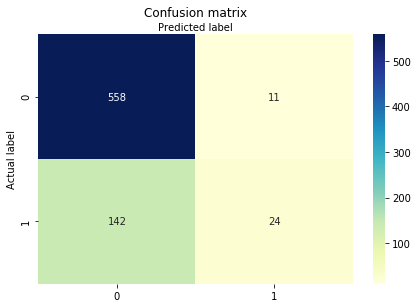

In [135]:
# Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [217]:
dump(logit_res2, 'logit.joblib')

['logit.joblib']

### Random forest
#### Training

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': [10, 30, 50],
    'n_estimators': [5, 10, 20, 50],
    'ccp_alpha' : [0, 0.01]#, 0.05, 0.1]
}
# Create a based model
rf = RandomForestClassifier( class_weight='balanced' )
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

In [146]:
best_grid

RandomForestClassifier(ccp_alpha=0, class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, n_estimators=50)

In [216]:
# Guardar modelo
dump(best_grid, 'rf.joblib')

['rf.joblib']

#### Testing and Results

In [136]:
# Predict
y_opt = best_grid.predict(X_test)
cnf_matrix = matrix_c( y_test, y_opt)

Accuracy :  0.71
Sensitivity :  0.79
Specificity :  0.42


Text(0.5, 257.44, 'Predicted label')

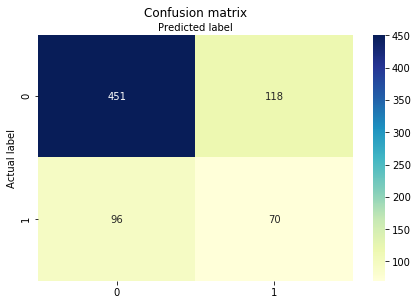

In [137]:
# Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Feature Importance

No handles with labels found to put in legend.


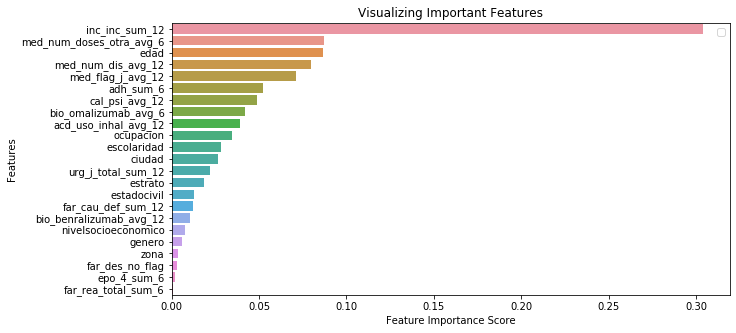

In [226]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(covariates, best_grid.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.reset_index(inplace = True)
importances = importances[importances['importance'] > 0].sort_values('importance', ascending = False).reset_index(drop = True)

# Creating a bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=importances['importance'], y=importances['index'])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### LightGBM

In [144]:
import lightgbm as lgb

In [152]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3, 4, 5],
    'min_child_samples': [10, 30, 50],
    'n_estimators': [5, 10, 20, 50],
}
# Create a based model
lgbm = lgb.LGBMClassifier( class_weight='balanced' )
# Instantiate the grid search model
grid_search_lg = GridSearchCV(estimator = lgbm, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search_lg.fit(X_train, y_train)
print(grid_search_lg.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.9s


{'bootstrap': True, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.6s finished


In [154]:
# Predict

best_grid_lgbm = grid_search_lg.best_estimator_
y_opt_lbg = best_grid_lgbm.predict(X_test)
cnf_matrix = matrix_c( y_test, y_opt_lbg)

Accuracy :  0.73
Sensitivity :  0.79
Specificity :  0.51


Text(0.5, 257.44, 'Predicted label')

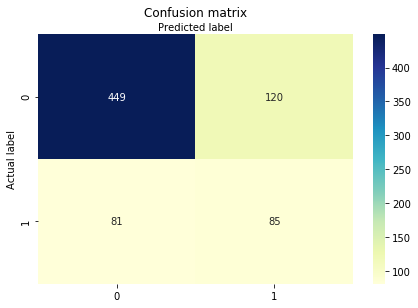

In [155]:
# Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [218]:
# Guarda modelo
dump(best_grid_lgbm, 'lgbm.joblib')

['lgbm.joblib']

#### Feature Importance

No handles with labels found to put in legend.


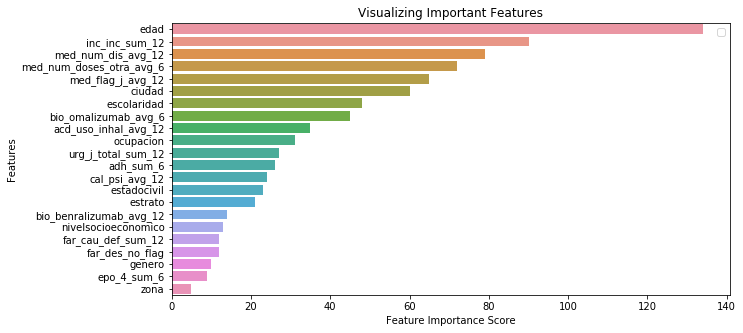

In [241]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(covariates, best_grid_lgbm.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.reset_index(inplace = True)
importances = importances[importances['importance'] > 0].sort_values('importance', ascending = False).reset_index(drop = True)

# Creating a bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=importances['importance'], y=importances['index'])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## 4. Evaluación Base Completa

In [159]:
# Prediccion rf
pred = best_grid.predict_proba(df_t[covariates])
lstrf = [item[1] for item in pred]

# Prediccion lg
df_t_rg = df_t[Significativas]
df_t_rg['Intercept'] = 1
pred_rl = logit_res2.predict(df_t_rg)

# Prediction lgbm 
pred = best_grid_lgbm.predict_proba(df_t[covariates])
lstlg = [item[1] for item in pred]

df_t['y_total_rf'] = lstrf
df_t['y_total_rl'] = pred_rl
df_t['y_total_lgbm'] = lstlg

### Distribuciones

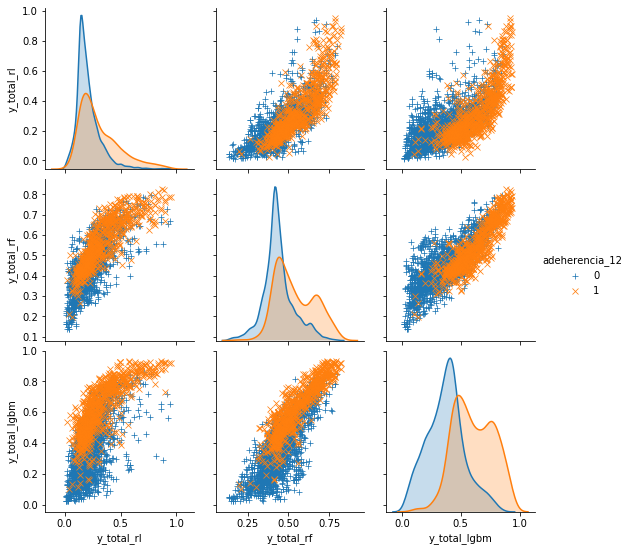

In [214]:
g = sns.pairplot(df_t[['adeherencia_12','y_total_rl','y_total_rf','y_total_lgbm']], hue="adeherencia_12", markers=["+", "x"])

### Matrices de confusion

In [139]:
_ = matrix_c( df_t['adeherencia_12'], round(df_t['y_total_rf']))

Accuracy :  0.74
Sensitivity :  0.8
Specificity :  0.53


In [140]:
_ = matrix_c( df_t['adeherencia_12'], round(df_t['y_total_rl']))

Accuracy :  0.78
Sensitivity :  0.98
Specificity :  0.15


In [161]:
_ = matrix_c( df_t['adeherencia_12'], round(df_t['y_total_lgbm']))

Accuracy :  0.79
Sensitivity :  0.82
Specificity :  0.68


### AUC

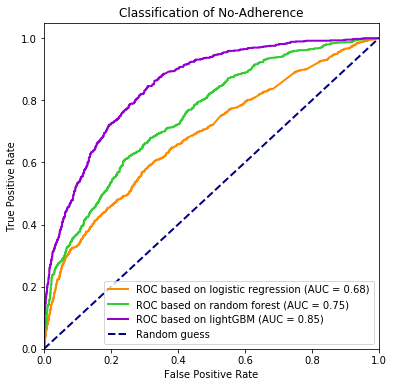

In [231]:
roc_rl = metrics.roc_curve(df_t['adeherencia_12'], df_t['y_total_rl'] )
auc_rl = metrics.auc( roc_rl[0], roc_rl[1] )

roc_rf = metrics.roc_curve(df_t['adeherencia_12'], df_t['y_total_rf'] )
auc_rf = metrics.auc( roc_rf[0], roc_rf[1] )

roc_lgbm = metrics.roc_curve(df_t['adeherencia_12'], df_t['y_total_lgbm'] )
auc_lgbm = metrics.auc( roc_lgbm[0], roc_lgbm[1] )

plt.figure(figsize=(6,6))
line_width = 2
plt.plot(roc_rl[0], roc_rl[1], color='darkorange', lw=line_width,
         label=f"ROC based on logistic regression (AUC = {auc_rl:0.2f})")

plt.plot(roc_rf[0], roc_rf[1], color='limegreen', lw=line_width,
         label=f"ROC based on random forest (AUC = {auc_rf:0.2f})")

plt.plot(roc_lgbm[0], roc_lgbm[1], color='darkviolet', lw=line_width,
         label=f"ROC based on lightGBM (AUC = {auc_lgbm:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of No-Adherence')
plt.legend(loc='lower right')
plt.show()

In [196]:
# Redondeo

df_t_r = df_t#[['adeherencia_12','y_total_rf','y_total_rl']]
df_t_r['y_total_rf_g'] = round(df_t_r['y_total_rf'],1)
df_t_r['y_total_rl_g'] = round(df_t_r['y_total_rl'],1)
df_t_r['y_total_lgbm_g'] = round(df_t_r['y_total_lgbm'],1)

In [ ]:
# Agrupacion en n-tiles

# n = 5
# 
# df_t_r = df_t#[['adeherencia_12','y_total_rf','y_total_rl']]
# df_t_r['y_total_rf_g'] = pd.qcut(df_t['y_total_rf'], n, labels = range(n))
# df_t_r['y_total_rl_g'] = pd.qcut(df_t['y_total_rl'], n, labels = range(n))

Text(0.5, 6.0, 'LightGBM')

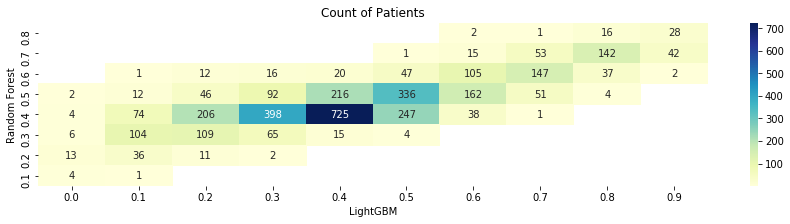

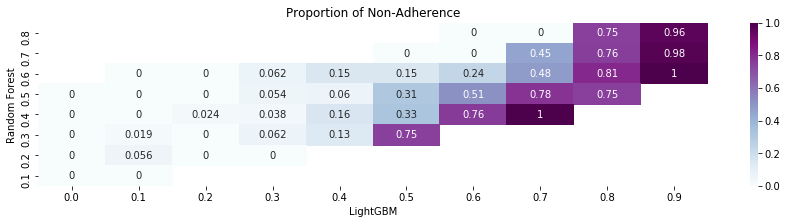

In [233]:
df_gwh = df_t_r.groupby(['y_total_rf_g','y_total_lgbm_g']).agg(avg=('adeherencia_12', 'mean'), cnt=('adeherencia_12', 'count')).reset_index()

df_gwh_p1 = df_gwh.pivot("y_total_rf_g", 'y_total_lgbm_g', "cnt")
df_gwh_p1.sort_index(level=0, ascending=False, inplace=True)

df_gwh_p2 = df_gwh.pivot("y_total_rf_g", 'y_total_lgbm_g', "avg")
df_gwh_p2.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_gwh_p1, cmap="YlGnBu", ax=ax, annot=True, fmt='g')
ax.set_title("Count of Patients")
plt.ylabel('Random Forest')
plt.xlabel('LightGBM')

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_gwh_p2, cmap="BuPu", ax=ax, annot=True) #RdYlGn
ax.set_title("Proportion of Non-Adherence")
plt.ylabel('Random Forest')
plt.xlabel('LightGBM')

## 5. Integración Modelos

In [234]:
clf = DecisionTreeClassifier(max_depth =2, min_samples_leaf = 30)

estimadores = ['y_total_rf','y_total_rl','y_total_lgbm']
clf = clf.fit(df_t[estimadores], df_t['adeherencia_12'])

In [235]:
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file='tree_limited_2.dot', feature_names = estimadores, 
                class_names=['Adh', 'No-Adh'], 
                filled=True, rounded=True, special_characters=True, 
                impurity='gini', proportion=True)

In [236]:
!dot -Tpng tree_limited_2.dot -o tree_limited.png -Gdpi=600

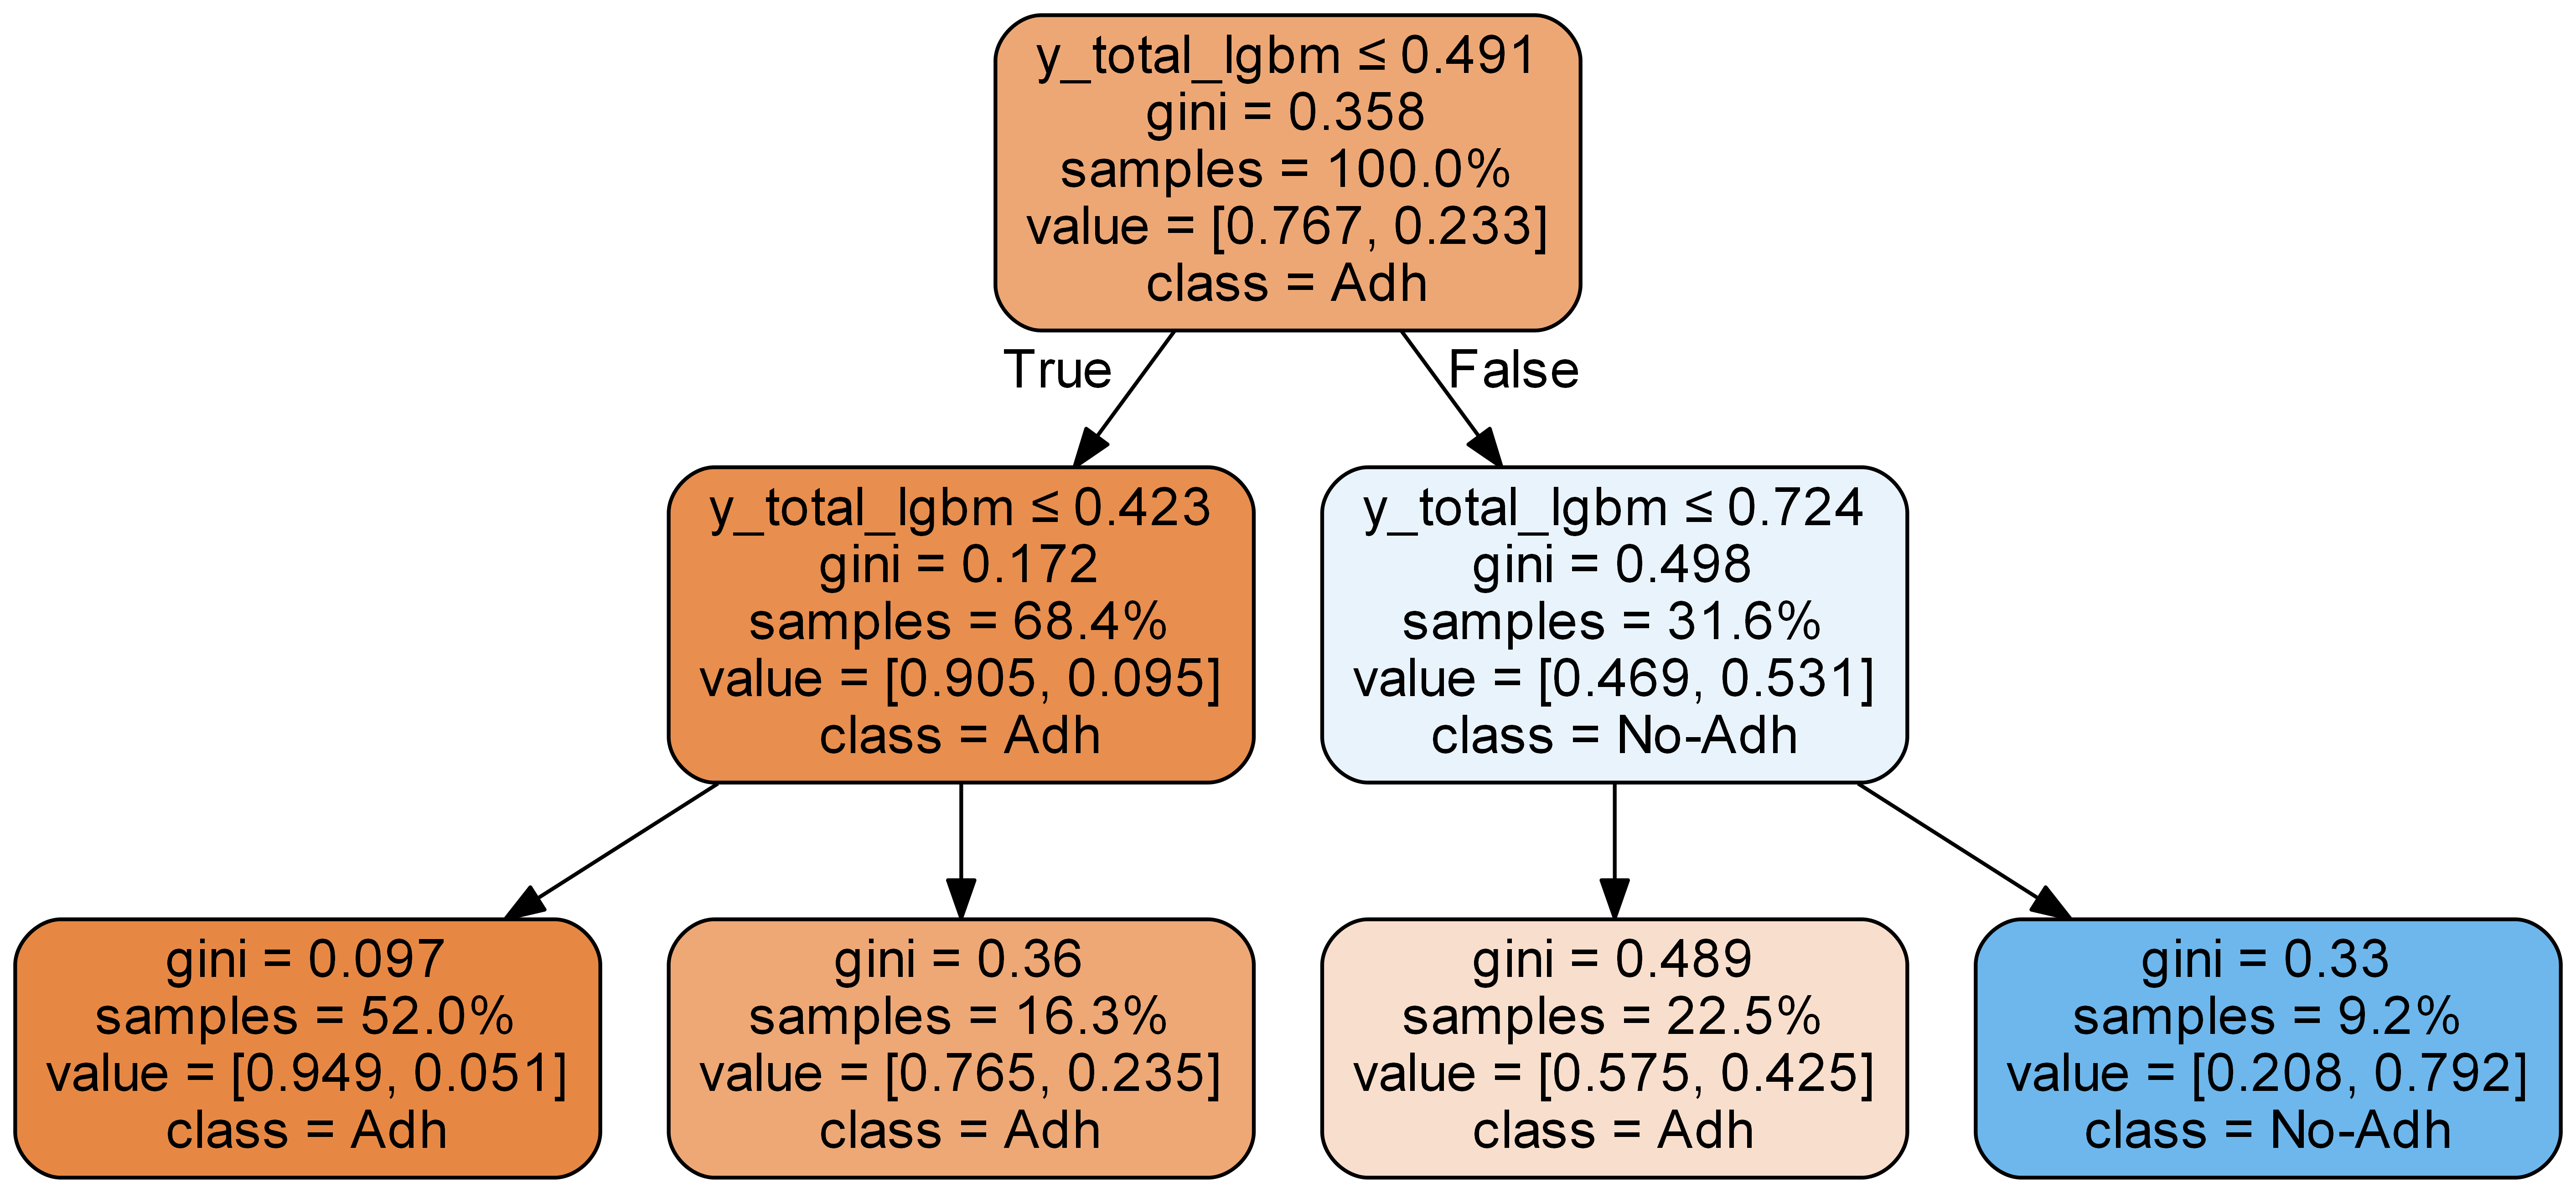

In [237]:
from IPython.display import Image
Image(filename = 'tree_limited.png')

## 6. Evaluacion Base Mensual

In [191]:
base_calificar = pd.read_csv( ruta_archivos + 'base_adeherencia_calificar_1.csv', sep='|' )
print(base_calificar.shape)
base_calificar_a = preprocesar( base_calificar, ['id','year','month'], ruta_archivos )

(872, 140)


In [192]:
base_calificar_a.head()

,id,year,month,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,urg_j_total_sum_12,...,adh_sum_6,genero,escolaridad,estadocivil,ciudad,estrato,zona,nivelsocioeconomico,ocupacion,edad
0,500547,2020,2,-1.0,840.833333,-1.0,-1.0,-1.0,-1.000000,0.0,...,0.0,1,3,2,26,3.0,1,3,5,58.0
1,500588,2020,2,-1.0,0.200000,-1.0,-1.0,-1.0,1.666667,-1.0,...,-1.0,1,2,0,5,2.0,1,4,1,15.0
2,502989,2020,2,-1.0,632.800000,-1.0,-1.0,-1.0,1.000000,-1.0,...,-1.0,1,6,0,26,3.0,1,3,0,30.0
3,506808,2020,2,-1.0,32.400000,-1.0,-1.0,-1.0,-1.000000,0.0,...,-1.0,1,1,0,4,1.0,1,3,1,11.0
4,512938,2020,2,-1.0,204.200000,-1.0,-1.0,-1.0,4.000000,0.0,...,1.0,0,3,0,26,3.0,1,3,5,22.0


In [193]:
base_calificar_a.shape

(838, 27)

In [276]:
covariates

Index(['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12',
       'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6',
       'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12',
       'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12',
       'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6', 'genero',
       'escolaridad', 'estadocivil', 'ciudad', 'estrato', 'zona',
       'nivelsocioeconomico', 'ocupacion', 'edad'],
      dtype='object')

In [211]:
# Prediccion rf
pred = best_grid.predict_proba(base_calificar_a[covariates])
lstrf = [item[1] for item in pred]

# Prediction lgbm 
pred = best_grid_lgbm.predict_proba(base_calificar_a[covariates])
lstlg = [item[1] for item in pred]

base_calificar_a['y_total_rf'] = lstrf
base_calificar_a['y_total_lgbm'] = lstlg

# Redondeo

base_calificar_a_r = base_calificar_a
base_calificar_a_r['y_total_rf_g'] = round(base_calificar_a_r['y_total_rf'],1)
base_calificar_a_r['y_total_lgbm_g'] = round(base_calificar_a_r['y_total_lgbm'],1)

Text(0.5, 6.0, 'Logistic Regression')

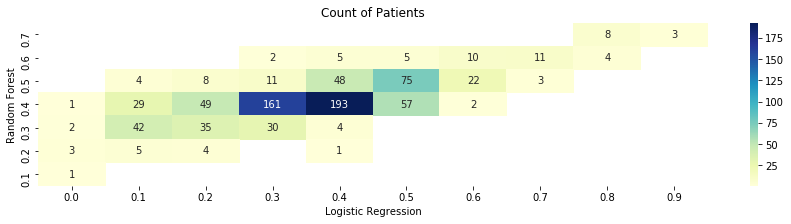

In [212]:
bc_gwh = base_calificar_a_r.groupby(['y_total_rf_g','y_total_lgbm_g']).agg(cnt=('id', 'count')).reset_index()

bc_gwh_p1 = bc_gwh.pivot("y_total_rf_g", 'y_total_lgbm_g', "cnt")
bc_gwh_p1.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(bc_gwh_p1, cmap="YlGnBu", ax=ax, annot=True, fmt='g')
ax.set_title("Count of Patients")
plt.ylabel('Random Forest')
plt.xlabel('Logistic Regression')

## 6. Clasificación en Grupos

In [11]:
def clasificacion_2( x ):
    y = '3 High'
    if (x['y_total_lgbm'] <= 0.423 ):
        y = '0 No Risk'
    elif (x['y_total_lgbm'] <= 0.491):
        y = '1 Low'
    elif (x['y_total_lgbm'] <= 0.724):
        y = '2 Medium'
    return y

In [279]:
df_t_r_c = df_t_r
df_t_r_c['grupo'] = df_t_r_c.apply(clasificacion_2, axis = 1)

conteos = df_t_r_c.groupby('grupo').count()['y_total_rf'].reset_index(name='cta').sort_values('grupo')
conteos['porcentaje'] = round( conteos['cta']/df_t_r_c.shape[0], 2 )
conteos

,grupo,cta,porcentaje
0,0 No Risk,1911,0.52
1,1 Low,602,0.16
2,2 Medium,822,0.22
3,3 High,336,0.09


In [240]:
bc_c = base_calificar_a_r
bc_c['grupo'] = bc_c.apply(clasificacion, axis = 1)

conteos = bc_c.groupby('grupo').count()['y_total_rf'].reset_index(name='cta').sort_values('grupo')
conteos['porcentaje'] = round( conteos['cta']/bc_c.shape[0], 2 )
conteos

,grupo,cta,porcentaje
0,0 No Risk,563,0.67
1,1 Low,151,0.18
2,2 Medium,103,0.12
3,3 High,21,0.03


In [ ]:
bc_c[['id','y_total_rf','y_total_rl','grupo']].to_csv(ruta_archivos+'base_calificada.csv', sep = '|', index = False)

## 6. Variación de Variables según Grupo

In [ ]:
len(covariates)

### Población Entrenamiento

In [1]:
df_t.head()

NameError: name 'df_t' is not defined

In [2]:
#print(importances['index'])
s_vars = ['med_num_doses_otra_avg_6','urg_j_total_sum_12','inc_inc_sum_12','adh_sum_6','nivelsocioeconomico','edad']
len(s_vars)

6

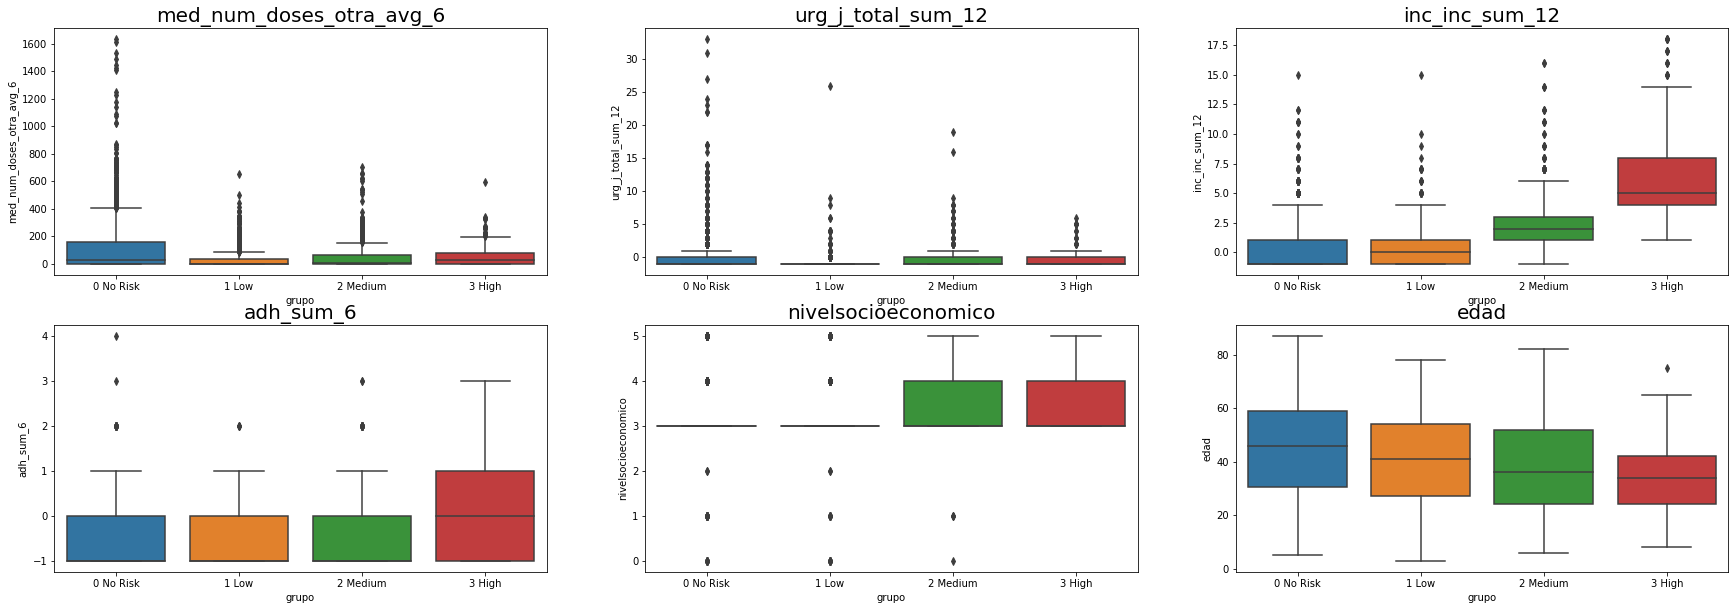

In [270]:
plt.figure(figsize=(30,10))

for i, var in enumerate(s_vars):
    
    plt.subplot( 2, 3, i+1 )
    
    sns.boxplot( x = 'grupo', y = var, data = df_t_r_c, order =['0 No Risk','1 Low','2 Medium', '3 High'])
    plt.title( var, size=20 )

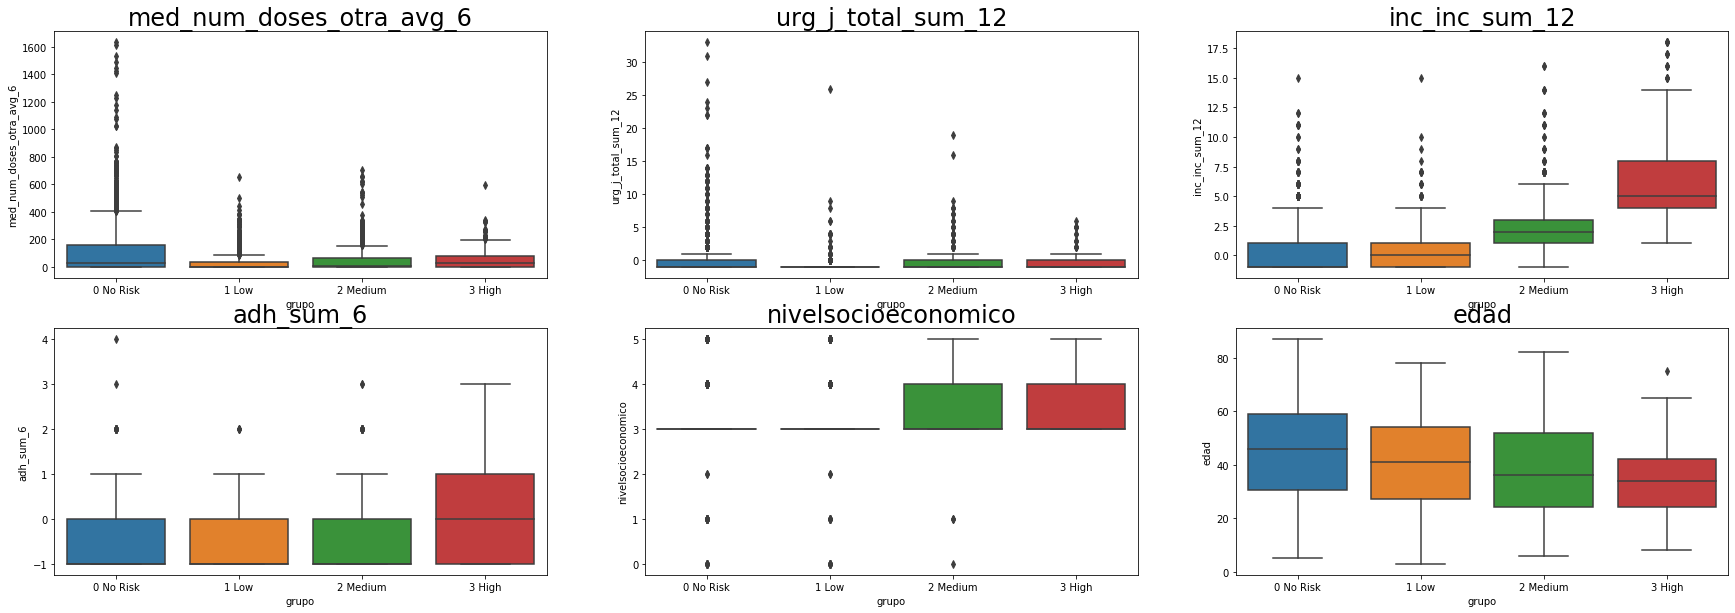

In [273]:
plt.figure(figsize=(30,10))

for i, var in enumerate(s_vars):
    
    plt.subplot(2,3,i+1)
    
    sns.boxplot( x = 'grupo', y = var, data = df_t_r_c, order =['0 No Risk','1 Low','2 Medium', '3 High'])
    plt.title( var, size = 24 )

### Población Front

In [274]:
mathias = base_calificar_a_r[['id','grupo','y_total_lgbm']+s_vars]

In [275]:
mathias.to_csv('base_lgbm.csv',sep = '|',index = False)

## Análsis Variable a Variable

In [10]:
modelo = load('lgbm.joblib') 

In [12]:
# Prediction
pred = modelo.predict_proba(df_t[covariates])
lstlg = [item[1] for item in pred]

df_t['y_lgbm'] = lstlg

In [13]:
df_t.head()

,id,year,month,adeherencia_12,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,...,genero,escolaridad,estadocivil,ciudad,estrato,zona,nivelsocioeconomico,ocupacion,edad,y_lgbm
0,500547,2016,7,0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1,3,2,26,3.0,1,3,5,54.0,0.406652
1,500547,2019,3,0,-1.0,1021.800000,-1.0,-1.0,-1.0,-1.0,...,1,3,2,26,3.0,1,3,5,57.0,0.046434
2,500547,2019,10,0,-1.0,259.200000,-1.0,-1.0,-1.0,3.0,...,1,3,2,26,3.0,1,3,5,57.0,0.209008
3,500547,2019,12,0,-1.0,596.833333,-1.0,-1.0,-1.0,3.0,...,1,3,2,26,3.0,1,3,5,58.0,0.122341
4,500547,2020,1,0,-1.0,732.000000,-1.0,-1.0,-1.0,3.0,...,1,3,2,26,3.0,1,3,5,58.0,0.047321


In [62]:
df_t.corr().sort_values('y_lgbm', ascending = False)['y_lgbm']

y_lgbm                      1.000000
inc_inc_sum_12              0.527589
adeherencia_12              0.527456
adh_sum_6                   0.187972
cal_psi_avg_12              0.164656
med_flag_j_avg_12           0.121046
acd_uso_inhal_avg_12        0.107729
far_cau_def_sum_12          0.107579
escolaridad                 0.099582
far_des_no_flag             0.090923
estrato                     0.080382
far_rea_total_sum_6         0.046620
id                          0.043107
nivelsocioeconomico         0.030869
anf_j_sum_12                0.012206
genero                     -0.003428
month                      -0.023880
zona                       -0.034178
ciudad                     -0.049173
epo_4_sum_6                -0.064916
ocupacion                  -0.081025
bio_omalizumab_avg_6       -0.083334
med_num_dis_avg_12         -0.093836
estadocivil                -0.143950
year                       -0.145932
urg_j_total_sum_12         -0.170593
bio_benralizumab_avg_12    -0.173668
e

In [36]:
abs(df_t.corr()).sort_values('y_lgbm', ascending = False)['y_lgbm']

y_lgbm                      1.000000
inc_inc_sum_12              0.527589
adeherencia_12              0.527456
med_num_doses_otra_avg_6    0.291388
edad                        0.267810
adh_sum_6                   0.187972
bio_benralizumab_avg_12     0.173668
urg_j_total_sum_12          0.170593
cal_psi_avg_12              0.164656
year                        0.145932
estadocivil                 0.143950
med_flag_j_avg_12           0.121046
acd_uso_inhal_avg_12        0.107729
far_cau_def_sum_12          0.107579
escolaridad                 0.099582
med_num_dis_avg_12          0.093836
far_des_no_flag             0.090923
bio_omalizumab_avg_6        0.083334
ocupacion                   0.081025
estrato                     0.080382
epo_4_sum_6                 0.064916
ciudad                      0.049173
far_rea_total_sum_6         0.046620
id                          0.043107
zona                        0.034178
nivelsocioeconomico         0.030869
month                       0.023880
a

In [49]:
df_t.corr().sort_values('y_lgbm', ascending = False)['y_lgbm']

analisis = ['inc_inc_sum_12','adh_sum_6','med_num_doses_otra_avg_6','bio_benralizumab_avg_12']

<Figure size 720x360 with 0 Axes>

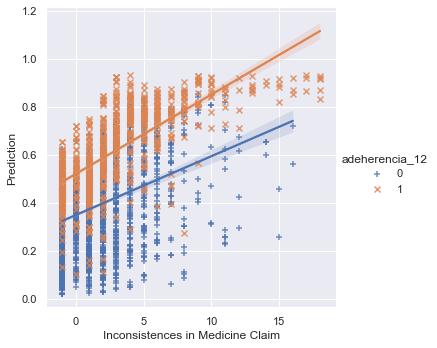

In [53]:
plt.figure(figsize=(10,5))
sns.lmplot(x="inc_inc_sum_12", y="y_lgbm", hue = 'adeherencia_12', markers = ['+','x'], data=df_t)
plt.xlabel('Inconsistences in Medicine Claim')
_ = plt.ylabel('Prediction')

<Figure size 720x360 with 0 Axes>

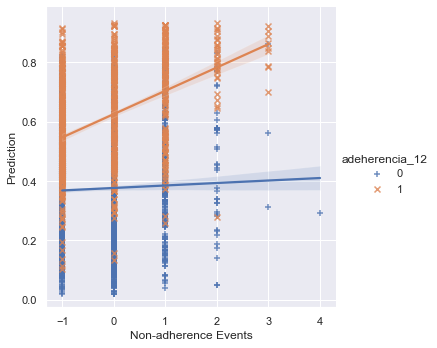

In [54]:
plt.figure(figsize=(10,5))
sns.lmplot(x="adh_sum_6", y="y_lgbm", hue = 'adeherencia_12', markers = ['+','x'], data=df_t)
plt.xlabel('Non-adherence Events')
_ = plt.ylabel('Prediction')

<Figure size 720x360 with 0 Axes>

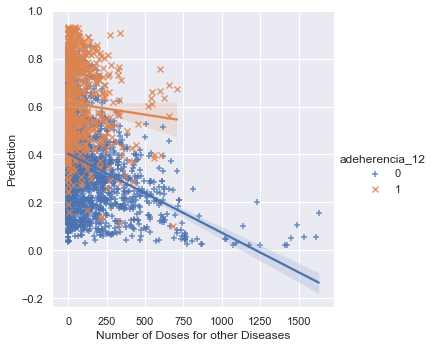

In [61]:
plt.figure(figsize=(10,5))
sns.lmplot(x="med_num_doses_otra_avg_6", y="y_lgbm", hue = 'adeherencia_12', markers = ['+','x'], data=df_t)
plt.xlabel('Number of Doses for other Diseases')
_ = plt.ylabel('Prediction')

<Figure size 720x360 with 0 Axes>

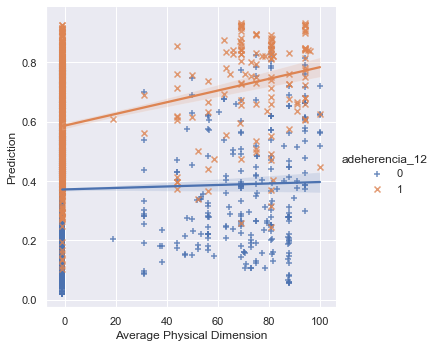

In [60]:
plt.figure(figsize=(10,5))
sns.lmplot(x="cal_psi_avg_12", y="y_lgbm", hue = 'adeherencia_12', markers = ['+','x'], data=df_t)
plt.xlabel('Average Physical Dimension')
_ = plt.ylabel('Prediction')